<a href="https://colab.research.google.com/github/iwatobipen/chemo_info/blob/master/chemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!python --version

Python 3.7.0


In [21]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit


--2018-10-31 13:08:02--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.16.19.10, 104.16.18.10, 2400:cb00:2048:1::6810:120a, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.16.19.10|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
reinstalling: python-3.7.0-hc3d631a_0 ...
Python 3.7.0
reinstalling: ca-certificates-2018.03.07-0 ...
reinstalling: conda-env-2.6.0-1 ...
reinstalling: libgcc-ng-8.2.0-hdf63c60_1 ...
reinstalling: libstdcxx-ng-8.2.0-hdf63c60_1 ...
reinstalling: libffi-3.2.1-hd88cf55_4 ...
reinstalling: ncurses-6.1-hf484d3e_0 ...
reinstalling: openssl-1.0.2p-h14c3975_0 ...
reinstalling: xz-5.2.4-h14c3975_4 ...
reinstalling: yaml-0.1.7-had09818_2 ...
reinstalling: zlib-1.2.11-ha838bed_2 ...
reinstalling: libedit-3.1.20170329-h6b74fdf_2 ...
reinstalling: readline-7.0-h7b6447c_5 ...
reinstalling: tk-

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [0]:
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole

In [28]:
rdBase.rdkitVersion

'2018.09.1'

In [41]:
trainsdf = Chem.SDMolSupplier(os.path.join( RDConfig.RDDocsDir, 'Book/data/solubility.train.sdf'))
testsdf = Chem.SDMolSupplier(os.path.join( RDConfig.RDDocsDir, 'Book/data/solubility.test.sdf'))
train_mols = [mol for mol in trainsdf if mol != None]
test_mols = [mol for mol in testsdf if mol != None]
print(len(train_mols), len(test_mols))

sol_class = {"(A) low":0, "(B) medium":1, "(C) high": 2}

1025 257


In [0]:
# 2048 bit vector
def mol2arr(mol):
  arr = np.zeros((1,))
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
  DataStructs.ConvertToNumpyArray(fp, arr)
  return arr

In [60]:
np.sum(mol2arr(train_mols[0]))

7.0

(2048,)


In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.layers import Activation, Dense, Dropout, Input
from keras.utils import np_utils


trainX = np.array([mol2arr(mol) for mol in train_mols])
trainY = [sol_class[mol.GetProp("SOL_classification")] for mol in train_mols]
trainY = np_utils.to_categorical(trainY)

testX = np.array([mol2arr(mol) for mol in test_mols])
testY = [sol_class[mol.GetProp("SOL_classification")] for mol in test_mols]
testY = np_utils.to_categorical(testY)


In [84]:
inputs = Input(shape=(2048,), name='input')
x = Dense(100, activation='relu', name='Layer1')(inputs)
x = Dense(20, activation='relu', name='Layer2')(x)
x = Dense(2, activation='relu', name='Layer3')(x)
predictions = Dense(3, activation='softmax', name='output')(x)

model = Model(inputs=inputs, outputs = predictions)
model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
model.summary()


model_int = Model(inputs=inputs, outputs=model.get_layer(name='Layer3').output)
model_int.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
Layer1 (Dense)               (None, 100)               204900    
_________________________________________________________________
Layer2 (Dense)               (None, 20)                2020      
_________________________________________________________________
Layer3 (Dense)               (None, 2)                 42        
_________________________________________________________________
output (Dense)               (None, 3)                 9         
Total params: 206,971
Trainable params: 206,971
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inpu

In [85]:
epochs = 50
hist = model.fit(np.array(trainX), trainY, batch_size=32, epochs=epochs)

Epoch 1/50
1025/1025 [==============================] - 0s 478us/step - loss: 1.0971 - acc: 0.4322
Epoch 2/50
1025/1025 [==============================] - 0s 175us/step - loss: 1.0896 - acc: 0.4244
Epoch 3/50
1025/1025 [==============================] - 0s 176us/step - loss: 1.0620 - acc: 0.4117
Epoch 4/50
1025/1025 [==============================] - 0s 178us/step - loss: 1.0195 - acc: 0.4351
Epoch 5/50
1025/1025 [==============================] - 0s 181us/step - loss: 0.9382 - acc: 0.5307
Epoch 6/50
1025/1025 [==============================] - 0s 173us/step - loss: 0.8520 - acc: 0.6010
Epoch 7/50
1025/1025 [==============================] - 0s 177us/step - loss: 0.7807 - acc: 0.6654
Epoch 8/50
1025/1025 [==============================] - 0s 189us/step - loss: 0.7262 - acc: 0.6995
Epoch 9/50
1025/1025 [==============================] - 0s 190us/step - loss: 0.6837 - acc: 0.7239
Epoch 10/50
1025/1025 [==============================] - 0s 186us/step - loss: 0.6427 - acc: 0.7434
Epoch 11/

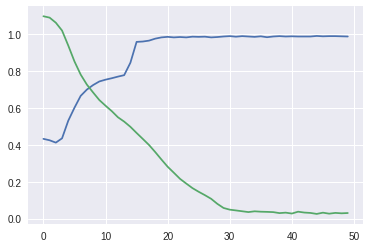

In [86]:
plt.plot(range(epochs), hist.history['acc'])
plt.plot(range(epochs), hist.history['loss'])

In [97]:
from sklearn.metrics import classification_report
predY = model.predict(testX)
predY = [np.argmax(y) for y in predY]
Y = [np.argmax(y) for y in testY]
print(classification_report(Y, predY))

             precision    recall  f1-score   support

          0       0.78      0.73      0.75       102
          1       0.69      0.78      0.73       115
          2       0.77      0.60      0.68        40

avg / total       0.74      0.73      0.73       257



In [0]:
intdata = model_int.predict(testX)
colormap = {0:"red", 1:"blue", 2:"green"}
c = [colormap[i] for i in Y]

In [103]:
intdata[:,0].shape

(257,)

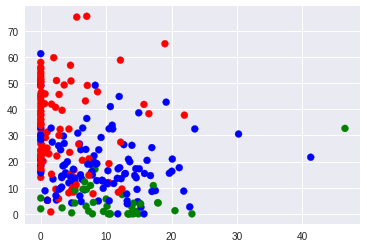

In [107]:
plt.scatter(intdata[:,0], intdata[:,1], c=c)